In [1]:
import sacc
import numpy as np
import pyccl as ccl
import rosatX as rx
import pyatomdb
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib import rc
import os
import pickle
import emcee
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica']})
rc('text', usetex=True)

In [2]:
from getdist import plots, MCSamples, loadMCSamples
from getdist.mcsamples import MCSamplesFromCobaya

In [3]:
cha = loadMCSamples('chains_cobaya/chain_cobaya_all',
                    settings={'ignore_rows': 0.2})
ch0 = loadMCSamples('chains_cobaya/chain_cobaya_bin0',
                    settings={'ignore_rows': 0.2})
ch1 = loadMCSamples('chains_cobaya/chain_cobaya_bin1',
                    settings={'ignore_rows': 0.2})
ch2 = loadMCSamples('chains_cobaya/chain_cobaya_bin2',
                    settings={'ignore_rows': 0.2})
ch3 = loadMCSamples('chains_cobaya/chain_cobaya_bin3',
                    settings={'ignore_rows': 0.2})

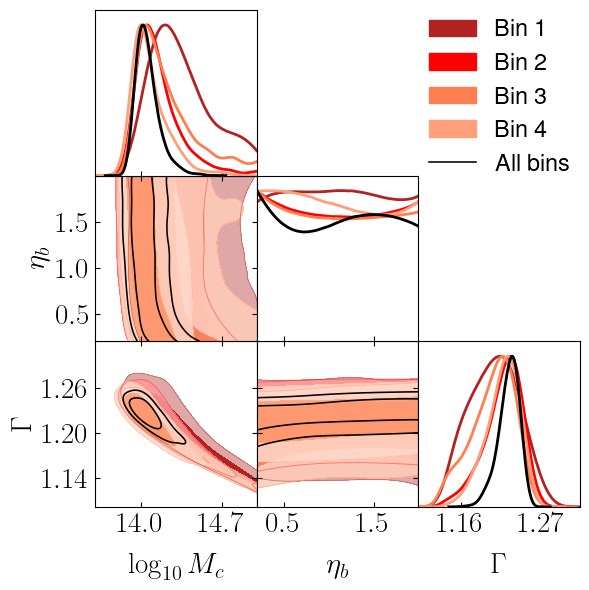

In [4]:
params = ['lMc', 'eta_b', 'gamma']
g = plots.get_subplot_plotter()
g.settings.legend_fontsize = 20
g.settings.axes_labelsize = 24
g.settings.axes_fontsize = 24
g.settings.linewidth=2
g.settings.figure_legend_frame=False
g.triangle_plot([ch0, ch1, ch2, ch3, cha],
                params, filled=[True, True, True, True, False],
                legend_labels=[f'Bin {i+1}' for i in range(4)] + ['All bins'],
                line_args=[{'lw': 2, 'color':'firebrick'},
                           {'lw': 2, 'color':'red'},
                           {'lw': 2, 'color':'coral'},
                           {'lw': 2, 'color':'lightsalmon'},
                           {'lw': 2, 'color':'black'}],                     
                contour_colors=['firebrick', 'red', 'coral', 'lightsalmon', 'black'])
plt.savefig('triangle_main.pdf')

In [5]:
chd = loadMCSamples('chains_cobaya/desy3wl_k1000_hsc_baryons_nocuts_nla_nside4096_lmin20_lmin100_lmin300_GNG',
                    settings={'ignore_rows': 0.3})
chd.addDerived(chd['M_c'], name='lMc', label='\log_{10}M_c')

In [6]:
lMa, pa = np.loadtxt("arico.csv", unpack=True, delimiter=',')
i = np.argsort(lMa)
lMa = lMa[i]
pa = pa[i]
pa /= np.amax(pa)

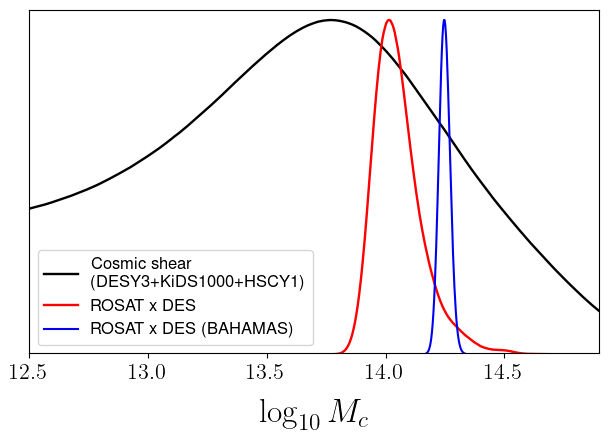

In [8]:
g = plots.get_single_plotter(width_inch=6)
g.settings.legend_fontsize = 12
g.settings.axes_labelsize = 24
g.settings.axes_fontsize = 16
g.plot_1d([chd, cha], 'lMc')
d = np.load("constraints_1d.npz")
plt.plot(d['lMc'], np.exp(-0.5*(d['chi2'][:, -1]-np.amin(d['chi2'][:, -1]))), '-', c='#0000EE')
#g.plot_1d(chd, 'M_c', colors=['#EE0000'])
#plt.plot(lMa, pa, '-', c='#EE0000')
plt.xlim([12.5, 14.9])
plt.ylim([0.003, 1.03])
g.add_legend(legend_labels=['Cosmic shear\n (DESY3+KiDS1000+HSCY1)',
                            'ROSAT x DES',
                            'ROSAT x DES (BAHAMAS)'],
             legend_loc='lower left', frameon=False);
plt.savefig("Mcfocus.pdf", bbox_inches='tight')

In [10]:
lc = rx.ROSATxLike(params_vary=['logTAGN'],
                   priors={'logTAGN': [7.5, 8.2]})
t = lc.get_model(logTAGN=d['logTAGN'][np.argmin(d['chi2'][:, -1])])

data/Jtot_Z0.30.pck


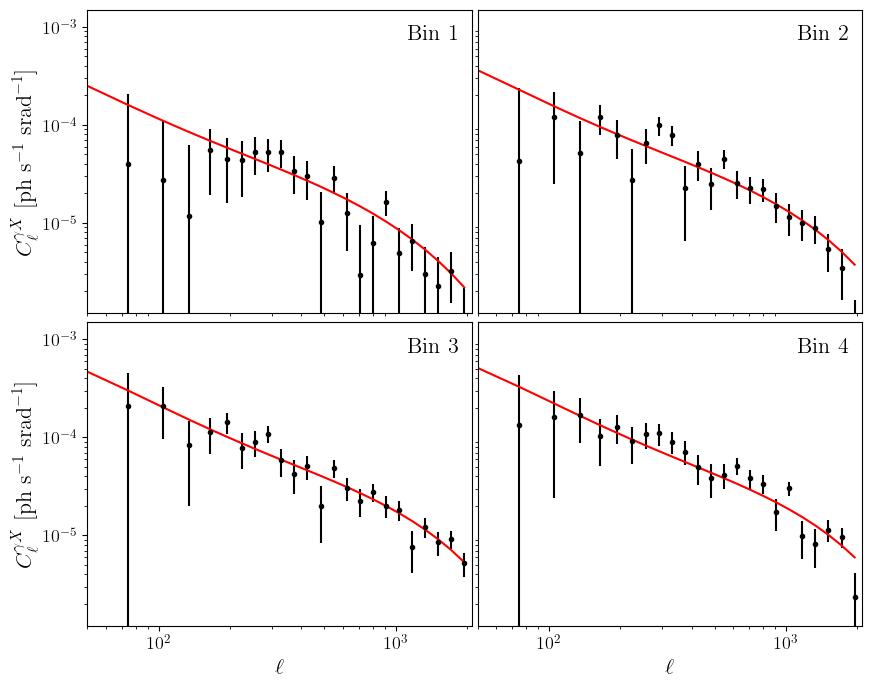

In [11]:
mosaic = """
AABB
CCDD
"""
fig, axes = plt.subplot_mosaic(mosaic=mosaic, figsize=(10,8))
plt.subplots_adjust(hspace=0.03, wspace=0.03)
for i, a in enumerate(['A', 'B', 'C', 'D']):
    ax = axes[a]
    clm = lc.cl_meta[i]
    clt = t[i]
    ax.errorbar(clm['ls'], clm['cld'], yerr=np.sqrt(np.diag(clm['cov'])), fmt='k.')
    ax.plot(clm['ls'], clt, 'r-')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_ylim([1.2E-6, 1.5E-3])
    ax.set_xlim([50, 2100])
    ax.tick_params(axis='both', labelsize=13)
    ax.text(0.83, 0.9, r'${\rm Bin\,\,%d}$'%(i+1), transform=ax.transAxes, fontsize=16)
axes['A'].set_xticks([])
axes['B'].set_xticks([])
axes['B'].set_yticks([])
axes['D'].set_yticks([])
for m in ['A', 'C']:
    axes[m].set_ylabel(r'$C_\ell^{\gamma X}\,\,[{\rm ph\,\,s^{-1}\,\,{\rm srad}^{-1}}]$', fontsize=16)
for m in ['C', 'D']:
    axes[m].set_xlabel(r'$\ell$', fontsize=16)
plt.savefig("allcl.pdf", bbox_inches='tight')